In [35]:
import pandas as pd
import os
import numpy as np
import glob
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import zscore
import matplotlib.pyplot as plt
from visualize_training.hmm import HMM
from visualize_training.visualize import visualize_dag, visualize_avg_log_likelihood, visualize_hmm_loss, visualize_all_seeds
from visualize_training.utils import training_run_json_to_csv, save_model, munge_data, load_model, get_difference_bt_means
pd.set_option('display.max_rows', 500)

In [36]:
def pizza_clock_classification(grad_sym_list, dist_irr_list, grad_sym_thresh=0.8, dist_irr_thresh=0.6):
    
    final_output = np.where(grad_sym_list>=grad_sym_thresh,"pizza",
                            np.where(dist_irr_list >=dist_irr_thresh,"clock",
                                     "pizza"))
    
    return final_output

In [37]:
parent_dir = "all_metrics"

## Combined Attention with all metrics

In [39]:
max_components = 8
cov_type = "diag"
n_seeds = 4
n_iter = 10
cols = ['l1', 'l2', 'trace', 'spectral', 'code_sparsity',
       'computational_sparsity', 'mean_lambda', 'variance_lambda', 'mean_w',
       'median_w', 'var_w', 'mean_b', 'median_b', 'var_b','grad_sym',
       'dist_irr', 'train_loss', 'eval_loss', 'train_accuracy',
       'eval_accuracy']

first_n = 400
hmm_model = HMM(max_components, cov_type, n_seeds, n_iter)
data_dir = parent_dir + f"/combined_attention/"
hmm_output = hmm_model.get_avg_log_likelihood(data_dir, cols)

visualize_avg_log_likelihood(hmm_output,"all metrics - modular_clock_pizza_run_combined_attention")

model_path = data_dir + '/model_all_metrics'
save_model(model_path,hmm_output)

all_metrics/combined_attention/
['all_metrics/combined_attention/lr0.001_adamw_seed1_scaling1.0_attn0.8.csv', 'all_metrics/combined_attention/lr0.001_adamw_seed0_scaling1.0_attn1.csv', 'all_metrics/combined_attention/lr0.001_adamw_seed0_scaling1.0_attn0.csv', 'all_metrics/combined_attention/lr0.001_adamw_seed2_scaling1.0_attn0.8.csv', 'all_metrics/combined_attention/lr0.001_adamw_seed3_scaling1.0_attn0.8.csv', 'all_metrics/combined_attention/lr0.001_adamw_seed0_scaling1.0_attn0.8.csv', 'all_metrics/combined_attention/lr0.001_adamw_seed1_scaling1.0_attn1.csv', 'all_metrics/combined_attention/lr0.001_adamw_seed1_scaling1.0_attn0.csv', 'all_metrics/combined_attention/lr0.001_adamw_seed3_scaling1.0_attn0.2.csv', 'all_metrics/combined_attention/lr0.001_adamw_seed2_scaling1.0_attn0.csv', 'all_metrics/combined_attention/lr0.001_adamw_seed0_scaling1.0_attn0.6.csv', 'all_metrics/combined_attention/lr0.001_adamw_seed2_scaling1.0_attn1.csv', 'all_metrics/combined_attention/lr0.001_adamw_seed0_sca

100%|██████████| 8/8 [00:25<00:00,  3.19s/it]


## All metrics


### All metrics, attention = 0

In [38]:
max_components = 8
cov_type = "diag"
n_seeds = 4
n_iter = 10
cols = ['l1', 'l2', 'trace', 'spectral', 'code_sparsity',
       'computational_sparsity', 'mean_lambda', 'variance_lambda', 'mean_w',
       'median_w', 'var_w', 'mean_b', 'median_b', 'var_b','grad_sym',
       'dist_irr', 'train_loss', 'eval_loss', 'train_accuracy',
       'eval_accuracy']

n_components = 4
attn = 0
data_dir = parent_dir + f"/combined_attention/"
model_path = data_dir + 'model_all_metrics.pkl'
hmm_output = load_model(model_path)
hmm_model = HMM(max_components, cov_type, n_seeds, n_iter)
hmm_model.best_model = hmm_output['best_model']
print("model_path: ", model_path)
print("best_model: ", hmm_model.best_model)
attn_data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"
model, data, best_predictions, lengths = munge_data(hmm_model, model_path, attn_data_dir, cols, n_components)

phases = list(set(hmm_model.best_model.predict(data, lengths=lengths)))
state_transitions = hmm_model.feature_importance(cols, data, best_predictions,phases,lengths)
best_model_transmat = model.transmat_

visualize_dag(best_model_transmat, edge_hover_dict = state_transitions)

model_path:  all_metrics/combined_attention/model_all_metrics.pkl
best_model:  GaussianHMM(n_components=8)
all_metrics/modular_clock_pizza_run_0/
['all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0/lr0.001_adamw_seed0_scaling1.0.csv']
-4938.468762515093


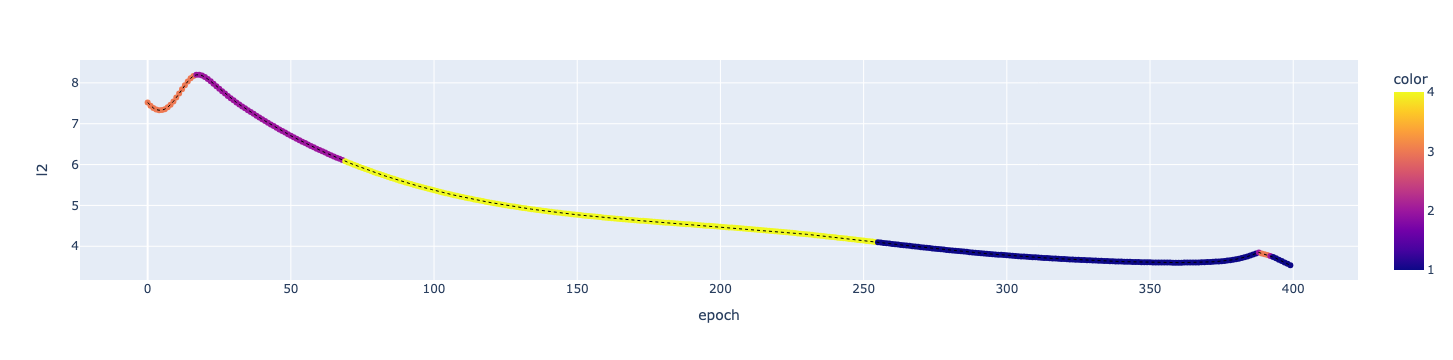

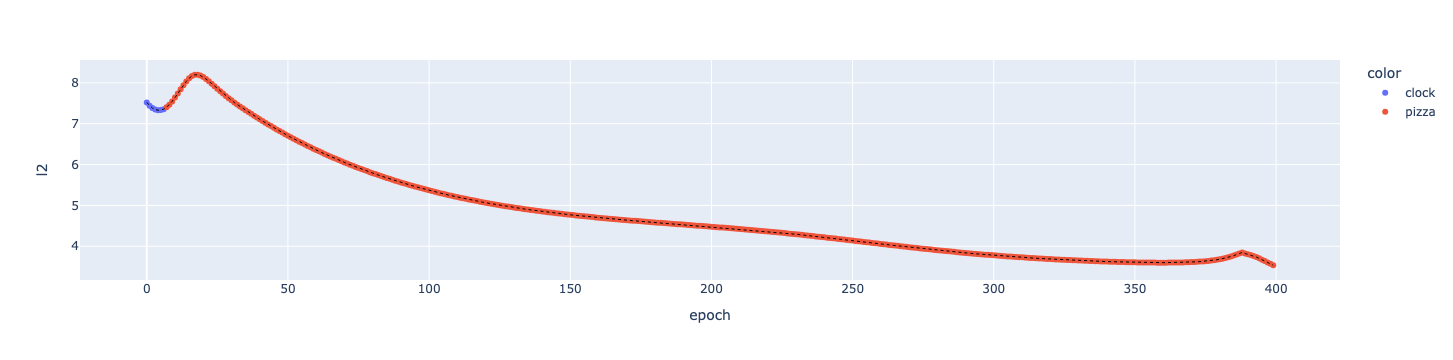

In [39]:
random_seed = 1
optimizer = "adamw"
lr = 0.001
scaling = 1.0
attn = 0
attn_data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"


training_run = pd.read_csv(f'{attn_data_dir}lr{lr}_{optimizer}_seed{random_seed}_scaling{scaling}.csv')
data  = np.apply_along_axis(zscore, 0, training_run[cols].to_numpy())
training_run['phases']= hmm_output['best_models'][n_components - 1].predict(data) + 1
training_run['pizza_clock_labels'] = pizza_clock_classification(training_run['grad_sym'], training_run['dist_irr'])
# training_run['phases']= hmm_model.best_model.predict(data)

visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='l2')
visualize_hmm_loss(training_run,phase_col = 'pizza_clock_labels', epoch_col='epoch', loss_col='l2')

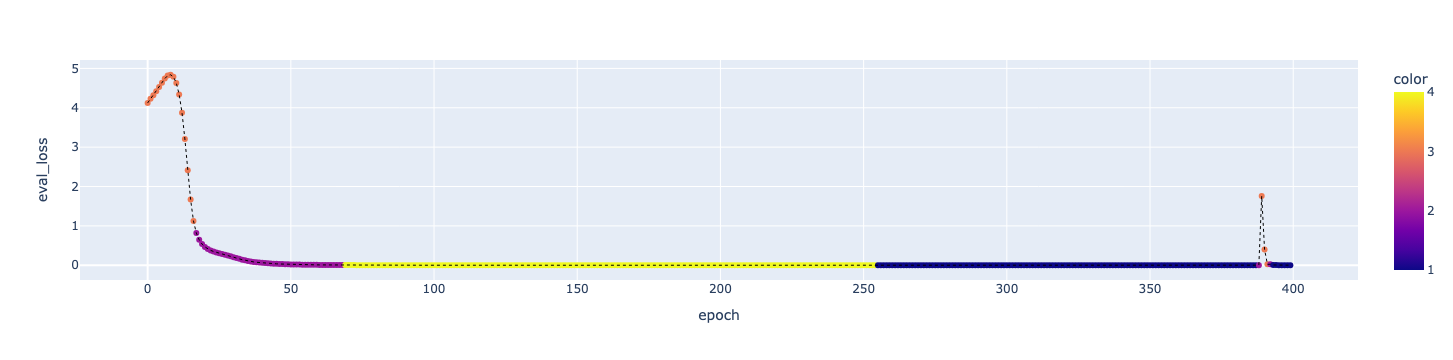

In [40]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='eval_loss')

### All metrics, attention = 0.2

In [7]:
max_components = 8
cov_type = "diag"
n_seeds = 4
n_iter = 10
cols = ['l1', 'l2', 'trace', 'spectral', 'code_sparsity',
       'computational_sparsity', 'mean_lambda', 'variance_lambda', 'mean_w',
       'median_w', 'var_w', 'mean_b', 'median_b', 'var_b','grad_sym',
       'dist_irr', 'train_loss', 'eval_loss', 'train_accuracy',
       'eval_accuracy']

n_components = 4
attn = 0.2
data_dir = parent_dir + f"/combined_attention/"
model_path = data_dir + 'model_all_metrics.pkl'
hmm_output = load_model(model_path)
hmm_model = HMM(max_components, cov_type, n_seeds, n_iter)
hmm_model.best_model = hmm_output['best_model']
print("model_path: ", model_path)
print("best_model: ", hmm_model.best_model)
attn_data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"
model, data, best_predictions, lengths = munge_data(hmm_model, model_path, attn_data_dir, cols, n_components)

phases = list(set(hmm_model.best_model.predict(data, lengths=lengths)))
state_transitions = hmm_model.feature_importance(cols, data, best_predictions,phases,lengths)
best_model_transmat = model.transmat_

visualize_dag(best_model_transmat, edge_hover_dict = state_transitions)

model_path:  all_metrics/combined_attention/model_all_metrics.pkl
best_model:  GaussianHMM(n_components=8)
all_metrics/modular_clock_pizza_run_0.2/
['all_metrics/modular_clock_pizza_run_0.2/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0.2/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0.2/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0.2/lr0.001_adamw_seed0_scaling1.0.csv']
-4478.869047597915


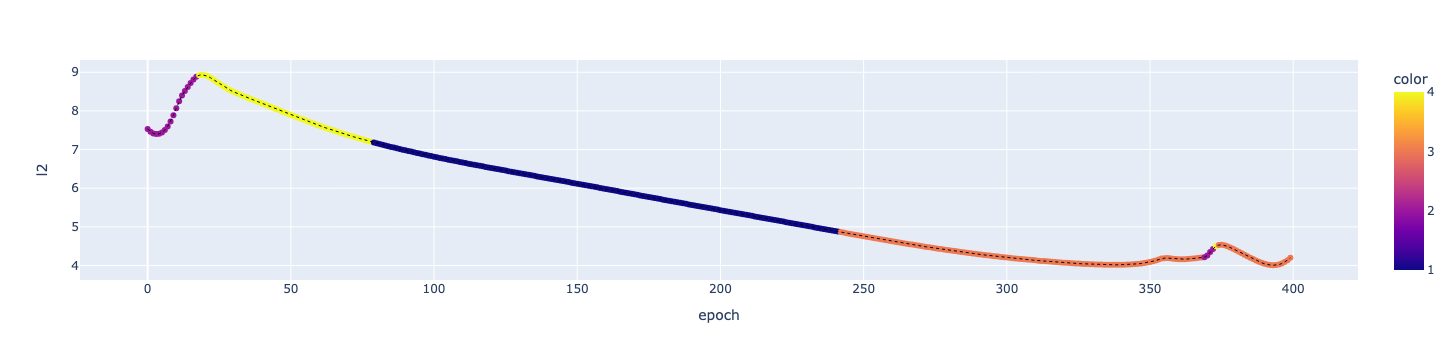

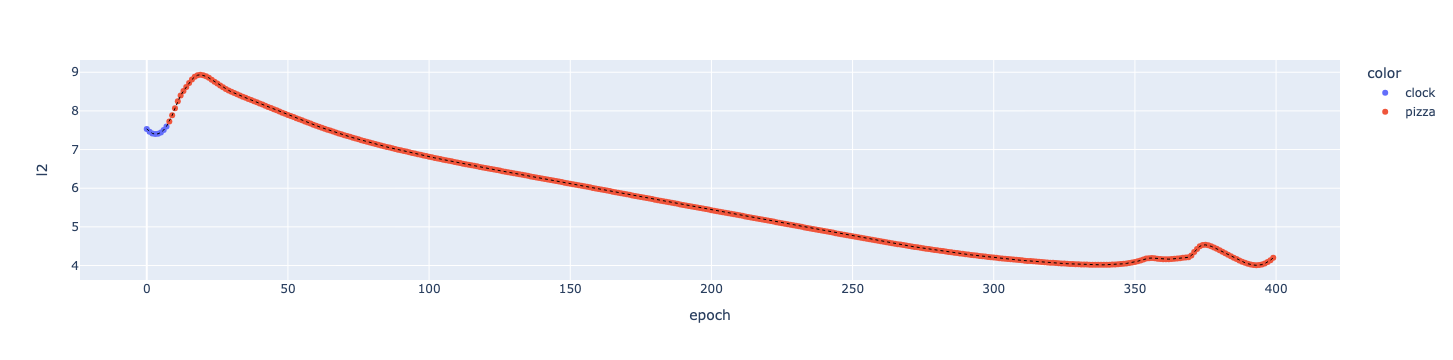

In [13]:
random_seed = 3
optimizer = "adamw"
lr = 0.001
scaling = 1.0
attn = 0.2
attn_data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"


training_run = pd.read_csv(f'{attn_data_dir}lr{lr}_{optimizer}_seed{random_seed}_scaling{scaling}.csv')
data  = np.apply_along_axis(zscore, 0, training_run[cols].to_numpy())
training_run['phases']= hmm_output['best_models'][n_components - 1].predict(data) + 1
training_run['pizza_clock_labels'] = pizza_clock_classification(training_run['grad_sym'], training_run['dist_irr'])
# training_run['phases']= hmm_model.best_model.predict(data)

visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='l2')
visualize_hmm_loss(training_run,phase_col = 'pizza_clock_labels', epoch_col='epoch', loss_col='l2')

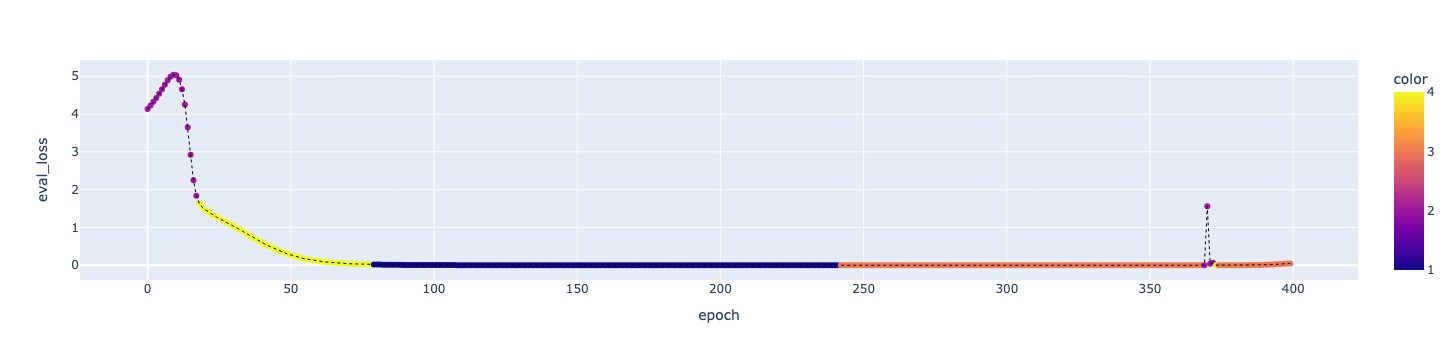

In [14]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='eval_loss')

### All metrics, attention = 0.4

In [15]:
max_components = 8
cov_type = "diag"
n_seeds = 4
n_iter = 10
cols = ['l1', 'l2', 'trace', 'spectral', 'code_sparsity',
       'computational_sparsity', 'mean_lambda', 'variance_lambda', 'mean_w',
       'median_w', 'var_w', 'mean_b', 'median_b', 'var_b','grad_sym',
       'dist_irr', 'train_loss', 'eval_loss', 'train_accuracy',
       'eval_accuracy']

n_components = 4
attn = 0.4
data_dir = parent_dir + f"/combined_attention/"
model_path = data_dir + 'model_all_metrics.pkl'
hmm_output = load_model(model_path)
hmm_model = HMM(max_components, cov_type, n_seeds, n_iter)
hmm_model.best_model = hmm_output['best_model']
print("model_path: ", model_path)
print("best_model: ", hmm_model.best_model)
attn_data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"
model, data, best_predictions, lengths = munge_data(hmm_model, model_path, attn_data_dir, cols, n_components)

phases = list(set(hmm_model.best_model.predict(data, lengths=lengths)))
state_transitions = hmm_model.feature_importance(cols, data, best_predictions,phases,lengths)
best_model_transmat = model.transmat_

visualize_dag(best_model_transmat, edge_hover_dict = state_transitions)

model_path:  all_metrics/combined_attention/model_all_metrics.pkl
best_model:  GaussianHMM(n_components=8)
all_metrics/modular_clock_pizza_run_0.4/
['all_metrics/modular_clock_pizza_run_0.4/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0.4/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0.4/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0.4/lr0.001_adamw_seed0_scaling1.0.csv']
-1384.355555052929


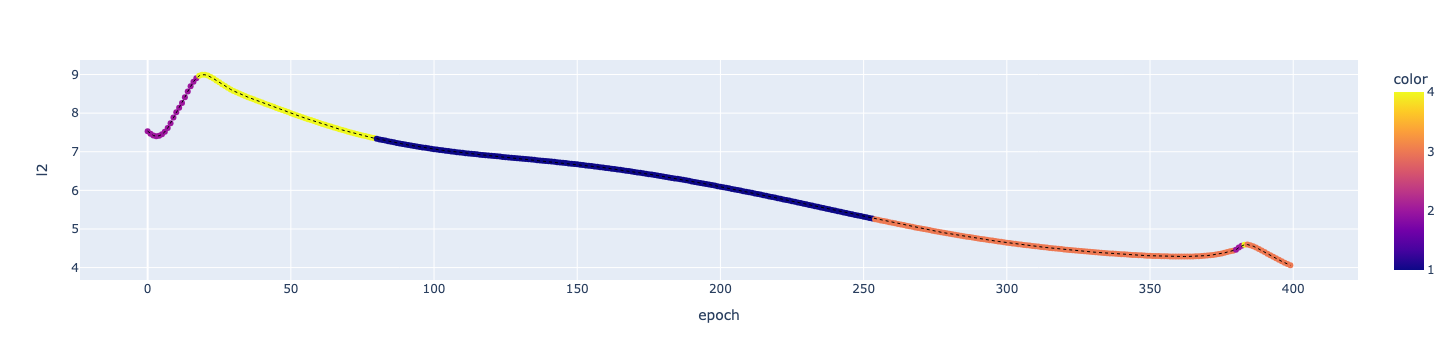

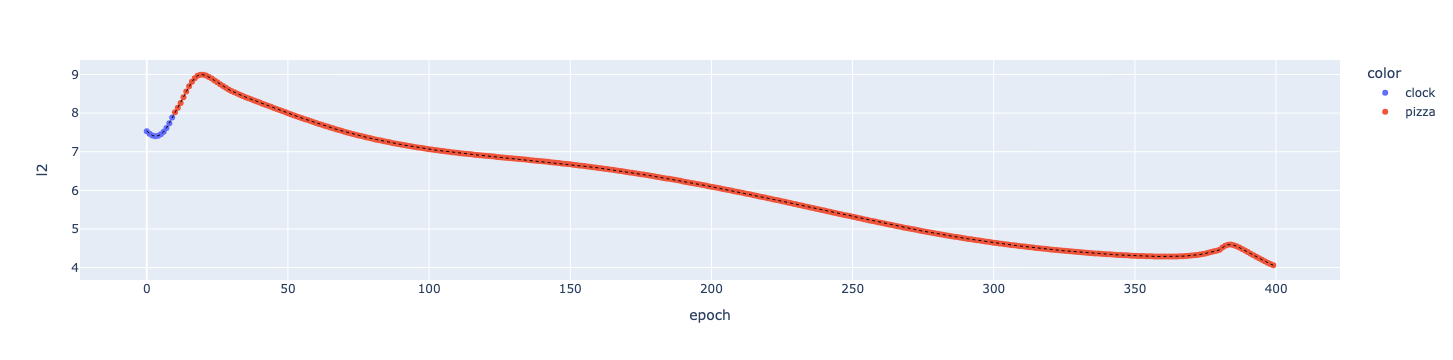

In [19]:
random_seed = 3
optimizer = "adamw"
lr = 0.001
scaling = 1.0
attn = 0.4
attn_data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"


training_run = pd.read_csv(f'{attn_data_dir}lr{lr}_{optimizer}_seed{random_seed}_scaling{scaling}.csv')
data  = np.apply_along_axis(zscore, 0, training_run[cols].to_numpy())
training_run['phases']= hmm_output['best_models'][n_components - 1].predict(data) + 1
training_run['pizza_clock_labels'] = pizza_clock_classification(training_run['grad_sym'], training_run['dist_irr'])
# training_run['phases']= hmm_model.best_model.predict(data)

visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='l2')
visualize_hmm_loss(training_run,phase_col = 'pizza_clock_labels', epoch_col='epoch', loss_col='l2')

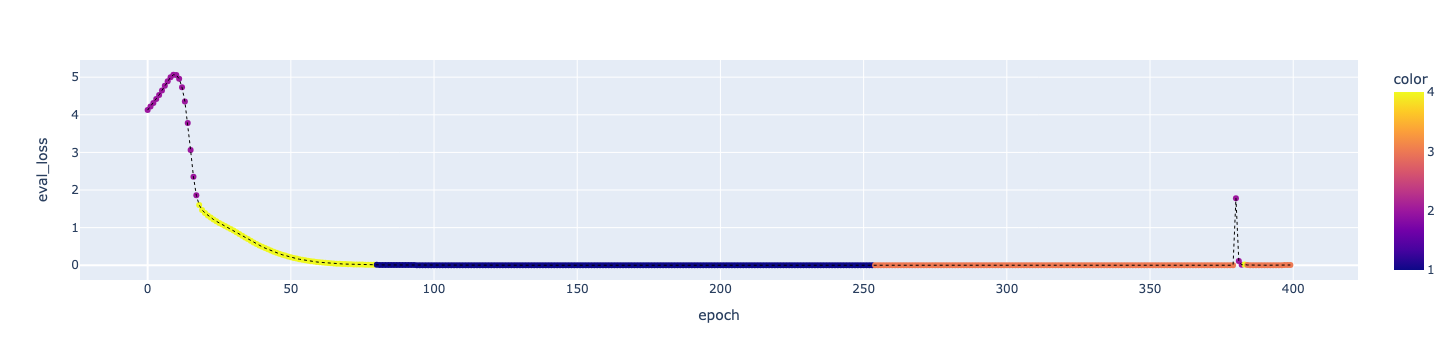

In [21]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='eval_loss')

### All metrics, attention = 0.6

In [22]:
max_components = 8
cov_type = "diag"
n_seeds = 4
n_iter = 10
cols = ['l1', 'l2', 'trace', 'spectral', 'code_sparsity',
       'computational_sparsity', 'mean_lambda', 'variance_lambda', 'mean_w',
       'median_w', 'var_w', 'mean_b', 'median_b', 'var_b','grad_sym',
       'dist_irr', 'train_loss', 'eval_loss', 'train_accuracy',
       'eval_accuracy']

n_components = 4
attn = 0.6
data_dir = parent_dir + f"/combined_attention/"
model_path = data_dir + 'model_all_metrics.pkl'
hmm_output = load_model(model_path)
hmm_model = HMM(max_components, cov_type, n_seeds, n_iter)
hmm_model.best_model = hmm_output['best_model']
print("model_path: ", model_path)
print("best_model: ", hmm_model.best_model)
attn_data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"
model, data, best_predictions, lengths = munge_data(hmm_model, model_path, attn_data_dir, cols, n_components)

phases = list(set(hmm_model.best_model.predict(data, lengths=lengths)))
state_transitions = hmm_model.feature_importance(cols, data, best_predictions,phases,lengths)
best_model_transmat = model.transmat_

visualize_dag(best_model_transmat, edge_hover_dict = state_transitions)

model_path:  all_metrics/combined_attention/model_all_metrics.pkl
best_model:  GaussianHMM(n_components=8)
all_metrics/modular_clock_pizza_run_0.6/
['all_metrics/modular_clock_pizza_run_0.6/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0.6/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0.6/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0.6/lr0.001_adamw_seed0_scaling1.0.csv']
-2067.734452559382


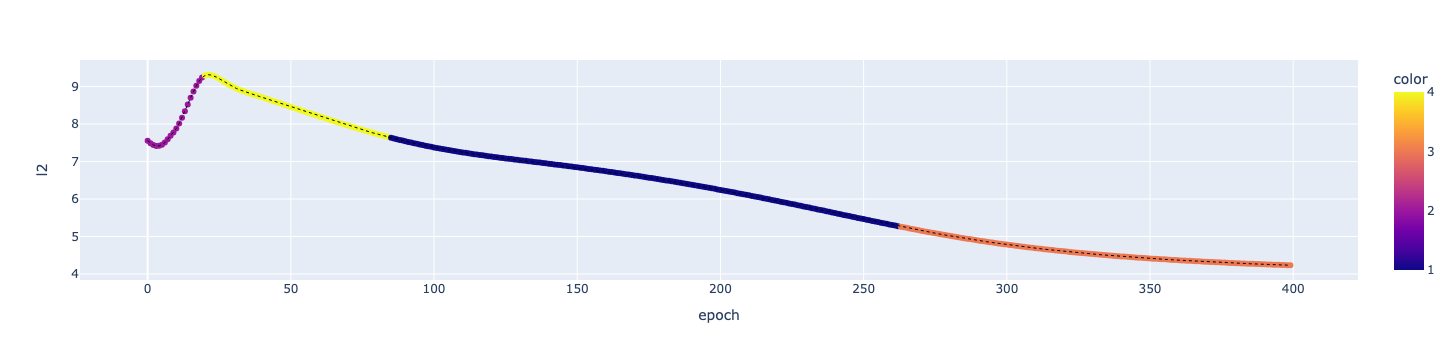

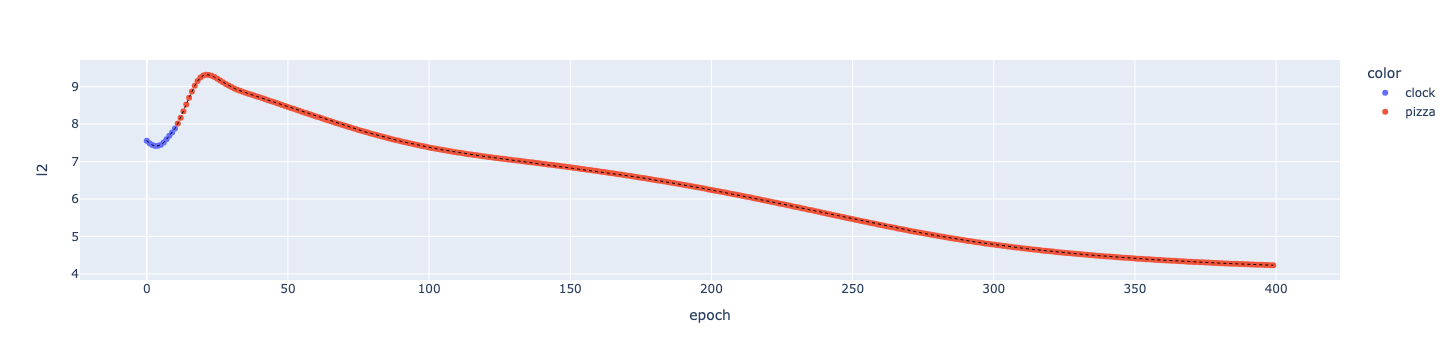

In [23]:
random_seed = 0
optimizer = "adamw"
lr = 0.001
scaling = 1.0
attn = 0.6
attn_data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"


training_run = pd.read_csv(f'{attn_data_dir}lr{lr}_{optimizer}_seed{random_seed}_scaling{scaling}.csv')
data  = np.apply_along_axis(zscore, 0, training_run[cols].to_numpy())
training_run['phases']= hmm_output['best_models'][n_components - 1].predict(data) + 1
training_run['pizza_clock_labels'] = pizza_clock_classification(training_run['grad_sym'], training_run['dist_irr'])
# training_run['phases']= hmm_model.best_model.predict(data)

visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='l2')
visualize_hmm_loss(training_run,phase_col = 'pizza_clock_labels', epoch_col='epoch', loss_col='l2')

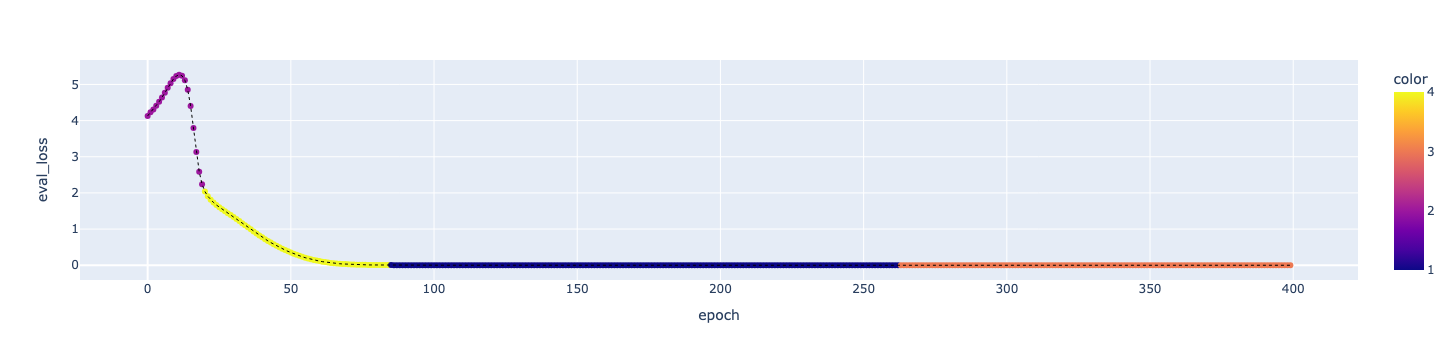

In [24]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='eval_loss')

### All metrics, attention = 0.8

In [25]:
max_components = 8
cov_type = "diag"
n_seeds = 4
n_iter = 10
cols = ['l1', 'l2', 'trace', 'spectral', 'code_sparsity',
       'computational_sparsity', 'mean_lambda', 'variance_lambda', 'mean_w',
       'median_w', 'var_w', 'mean_b', 'median_b', 'var_b','grad_sym',
       'dist_irr', 'train_loss', 'eval_loss', 'train_accuracy',
       'eval_accuracy']

n_components = 4
attn = 0.8
data_dir = parent_dir + f"/combined_attention/"
model_path = data_dir + 'model_all_metrics.pkl'
hmm_output = load_model(model_path)
hmm_model = HMM(max_components, cov_type, n_seeds, n_iter)
hmm_model.best_model = hmm_output['best_model']
print("model_path: ", model_path)
print("best_model: ", hmm_model.best_model)
attn_data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"
model, data, best_predictions, lengths = munge_data(hmm_model, model_path, attn_data_dir, cols, n_components)

phases = list(set(hmm_model.best_model.predict(data, lengths=lengths)))
state_transitions = hmm_model.feature_importance(cols, data, best_predictions,phases,lengths)
best_model_transmat = model.transmat_

visualize_dag(best_model_transmat, edge_hover_dict = state_transitions)

model_path:  all_metrics/combined_attention/model_all_metrics.pkl
best_model:  GaussianHMM(n_components=8)
all_metrics/modular_clock_pizza_run_0.8/
['all_metrics/modular_clock_pizza_run_0.8/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0.8/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0.8/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_0.8/lr0.001_adamw_seed0_scaling1.0.csv']
-2896.6393362086546


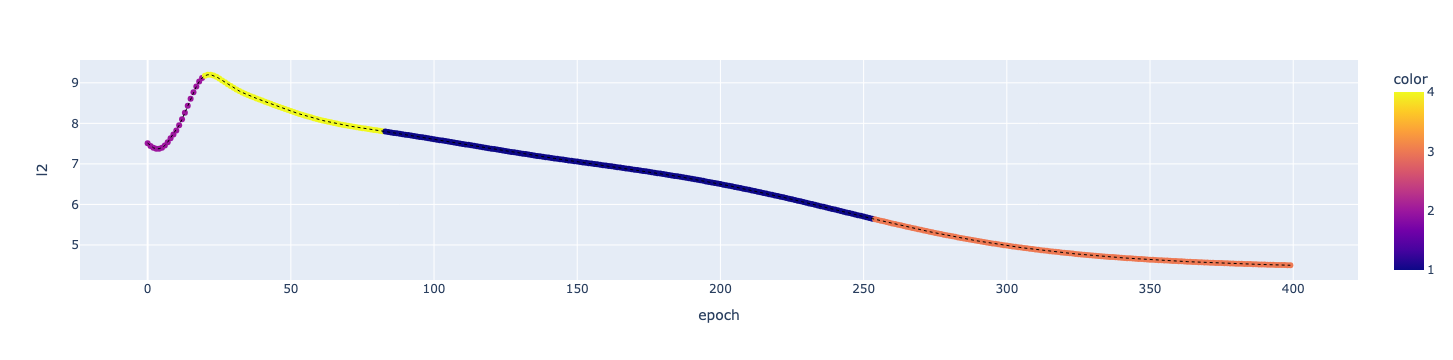

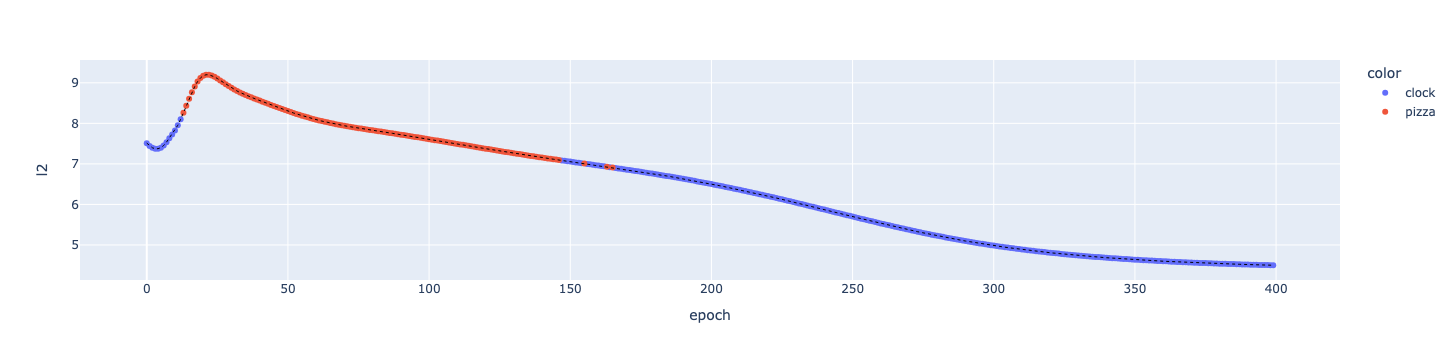

In [26]:
random_seed = 0
optimizer = "adamw"
lr = 0.001
scaling = 1.0
attn = 0.8
attn_data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"


training_run = pd.read_csv(f'{attn_data_dir}lr{lr}_{optimizer}_seed{random_seed}_scaling{scaling}.csv')
data  = np.apply_along_axis(zscore, 0, training_run[cols].to_numpy())
training_run['phases']= hmm_output['best_models'][n_components - 1].predict(data) + 1
training_run['pizza_clock_labels'] = pizza_clock_classification(training_run['grad_sym'], training_run['dist_irr'])
# training_run['phases']= hmm_model.best_model.predict(data)

visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='l2')
visualize_hmm_loss(training_run,phase_col = 'pizza_clock_labels', epoch_col='epoch', loss_col='l2')

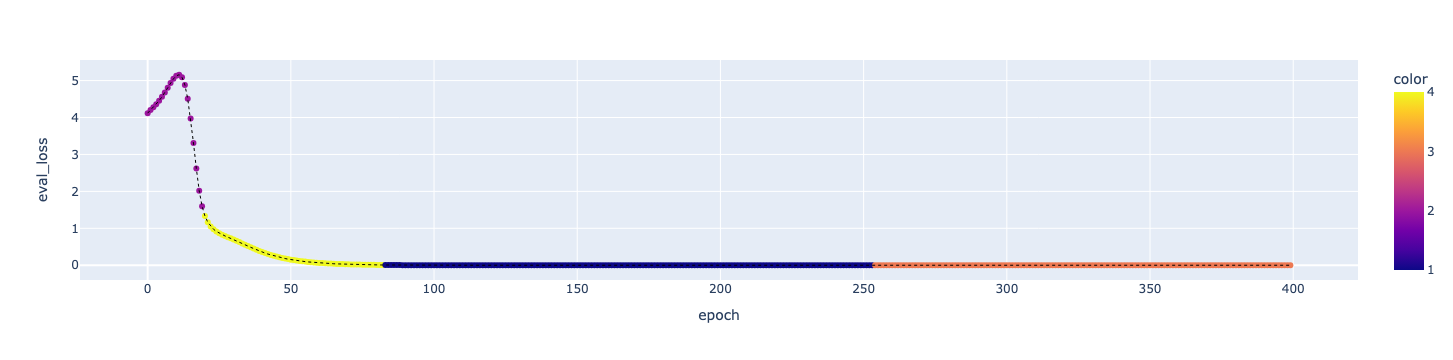

In [27]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='eval_loss')

### All metrics, attention = 1

In [28]:
max_components = 8
cov_type = "diag"
n_seeds = 4
n_iter = 10
cols = ['l1', 'l2', 'trace', 'spectral', 'code_sparsity',
       'computational_sparsity', 'mean_lambda', 'variance_lambda', 'mean_w',
       'median_w', 'var_w', 'mean_b', 'median_b', 'var_b','grad_sym',
       'dist_irr', 'train_loss', 'eval_loss', 'train_accuracy',
       'eval_accuracy']

n_components = 4
attn = 1
data_dir = parent_dir + f"/combined_attention/"
model_path = data_dir + 'model_all_metrics.pkl'
hmm_output = load_model(model_path)
hmm_model = HMM(max_components, cov_type, n_seeds, n_iter)
hmm_model.best_model = hmm_output['best_model']
print("model_path: ", model_path)
print("best_model: ", hmm_model.best_model)
attn_data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"
model, data, best_predictions, lengths = munge_data(hmm_model, model_path, attn_data_dir, cols, n_components)

phases = list(set(hmm_model.best_model.predict(data, lengths=lengths)))
state_transitions = hmm_model.feature_importance(cols, data, best_predictions,phases,lengths)
best_model_transmat = model.transmat_

visualize_dag(best_model_transmat, edge_hover_dict = state_transitions)

model_path:  all_metrics/combined_attention/model_all_metrics.pkl
best_model:  GaussianHMM(n_components=8)
all_metrics/modular_clock_pizza_run_1/
['all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed2_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed3_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed1_scaling1.0.csv', 'all_metrics/modular_clock_pizza_run_1/lr0.001_adamw_seed0_scaling1.0.csv']
-6352.702460632403


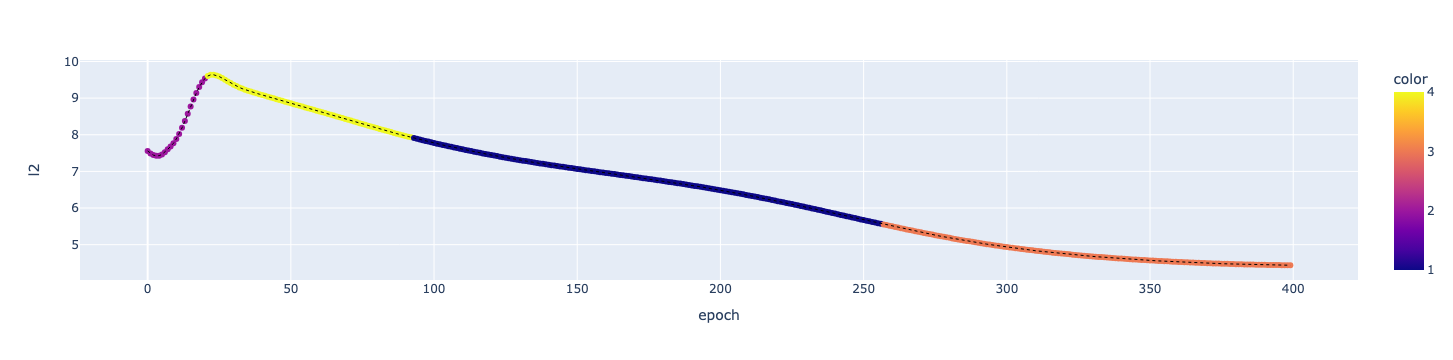

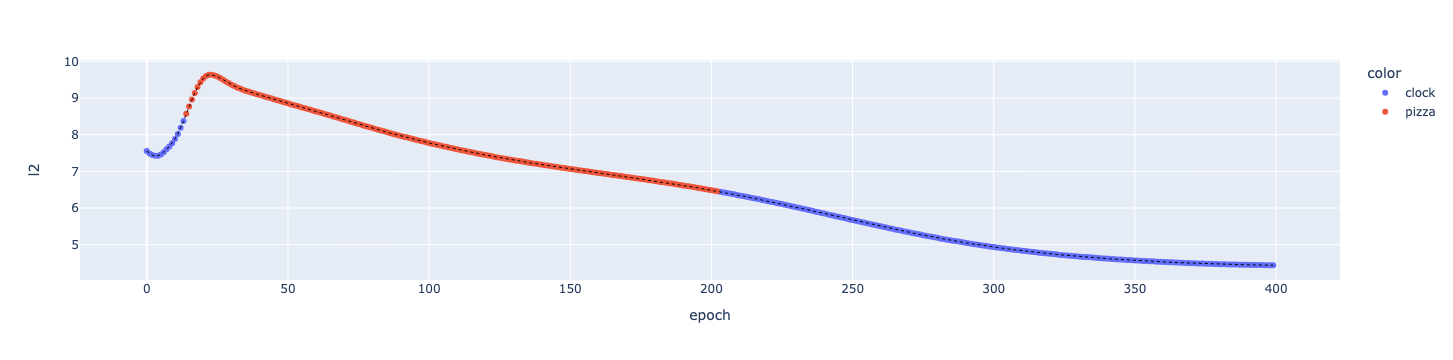

In [29]:
random_seed = 0
optimizer = "adamw"
lr = 0.001
scaling = 1.0
attn = 1
attn_data_dir = parent_dir + f"/modular_clock_pizza_run_{attn}/"


training_run = pd.read_csv(f'{attn_data_dir}lr{lr}_{optimizer}_seed{random_seed}_scaling{scaling}.csv')
data  = np.apply_along_axis(zscore, 0, training_run[cols].to_numpy())
training_run['phases']= hmm_output['best_models'][n_components - 1].predict(data) + 1
training_run['pizza_clock_labels'] = pizza_clock_classification(training_run['grad_sym'], training_run['dist_irr'])
# training_run['phases']= hmm_model.best_model.predict(data)

visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='l2')
visualize_hmm_loss(training_run,phase_col = 'pizza_clock_labels', epoch_col='epoch', loss_col='l2')

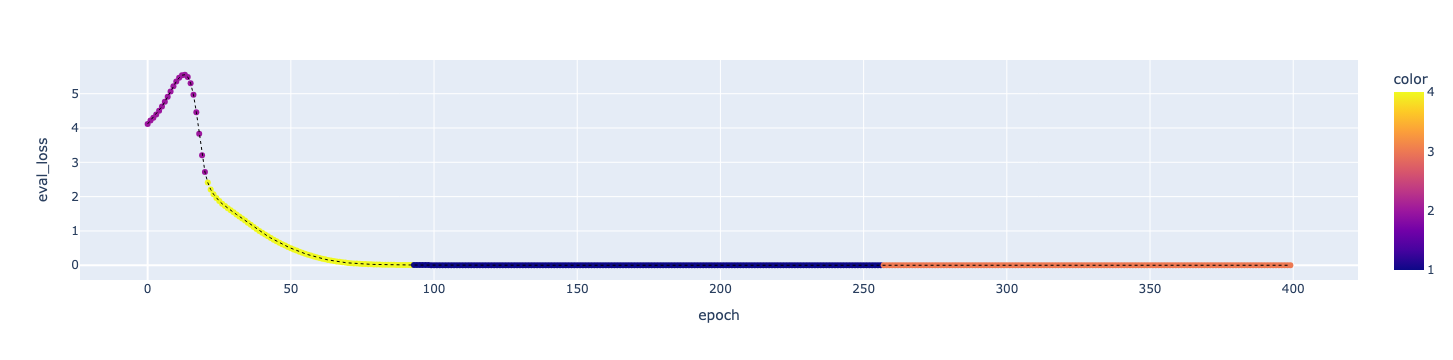

In [30]:
visualize_hmm_loss(training_run,phase_col = 'phases', epoch_col='epoch', loss_col='eval_loss')